In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# импортируем датасет
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
pd.set_option("display.width", 400)
pd.set_option('display.max_rows', None)

data = pd.read_csv("houses.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 0. Посмотрим на данные

In [3]:
print("types:", data.dtypes, sep='\n')
print('------')
print("shape:", data.shape, sep='\n')

types:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           

In [4]:
print("describe:", data.describe, sep='\n')

describe:
<bound method NDFrame.describe of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice
0        1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub  ...        0    NaN    NaN         NaN       0      2   2008        WD         Normal     208500
1        2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub  ...        0    NaN    NaN         NaN       0      5   2007        WD         Normal     181500
2        3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0      9   2008        WD         Normal     223500
3        4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0      2   2006        WD   

In [5]:
print("nulls:", data.isnull().sum().sort_values(ascending=False), sep='\n')

nulls:
PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
Hea

## 0. Разделим данные

In [7]:
data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## 1. Посмотрим на данные by themselves

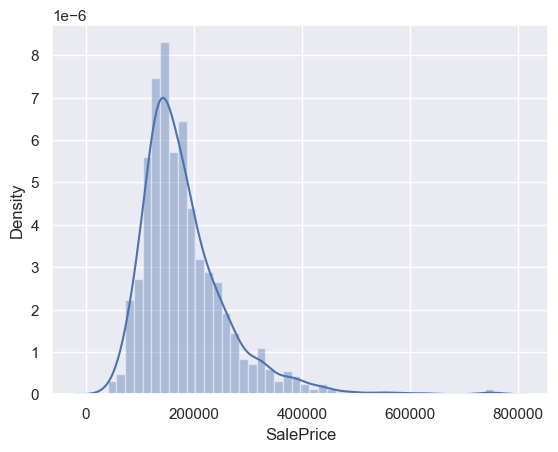

In [9]:
sns.distplot(y_train)
plt.show()

В целом ничего необычного, домов с отрцательной стоимостью не наблюдается, как и домов со стоимостью > 10^6

Порисуем скаттеры по части признаков, чтобы посмотреть нет ли выбросов там

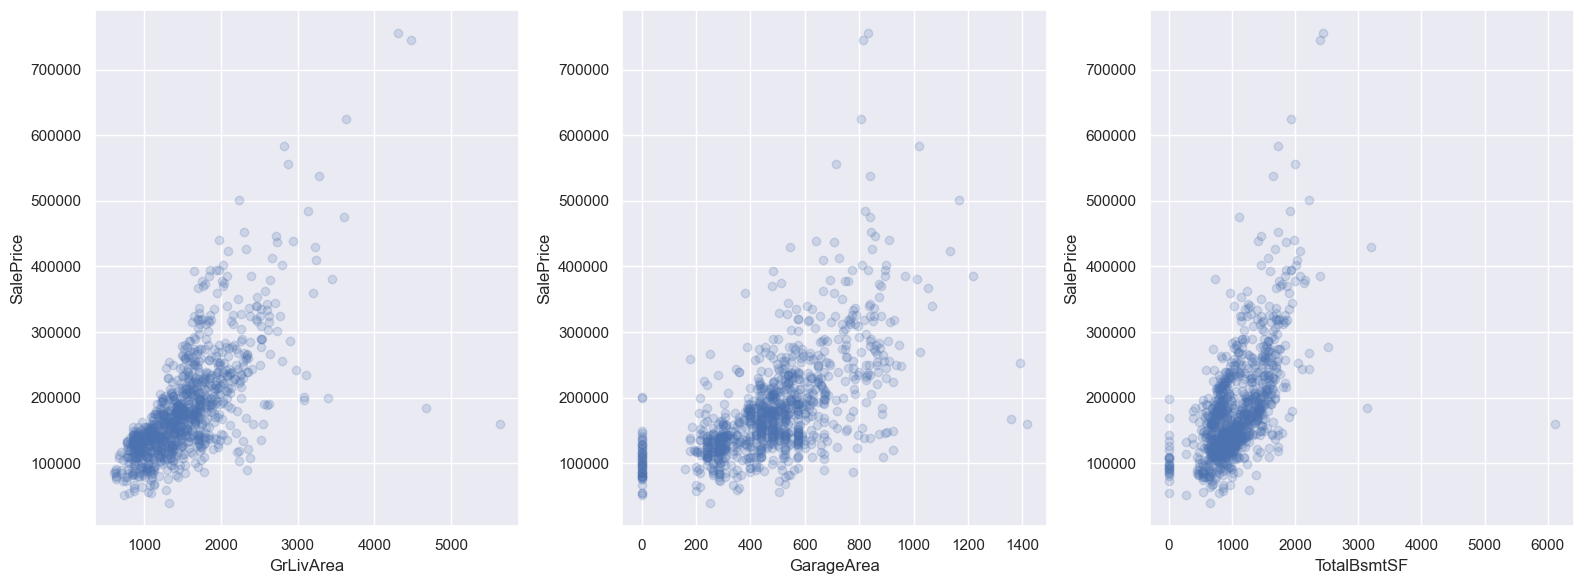

In [12]:
fig, axs = plt.subplots(figsize=(16, 6), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()
plt.show()

Ничего сверхнеобычного ненаблюдается

## 2. Посмотрим на корреляции

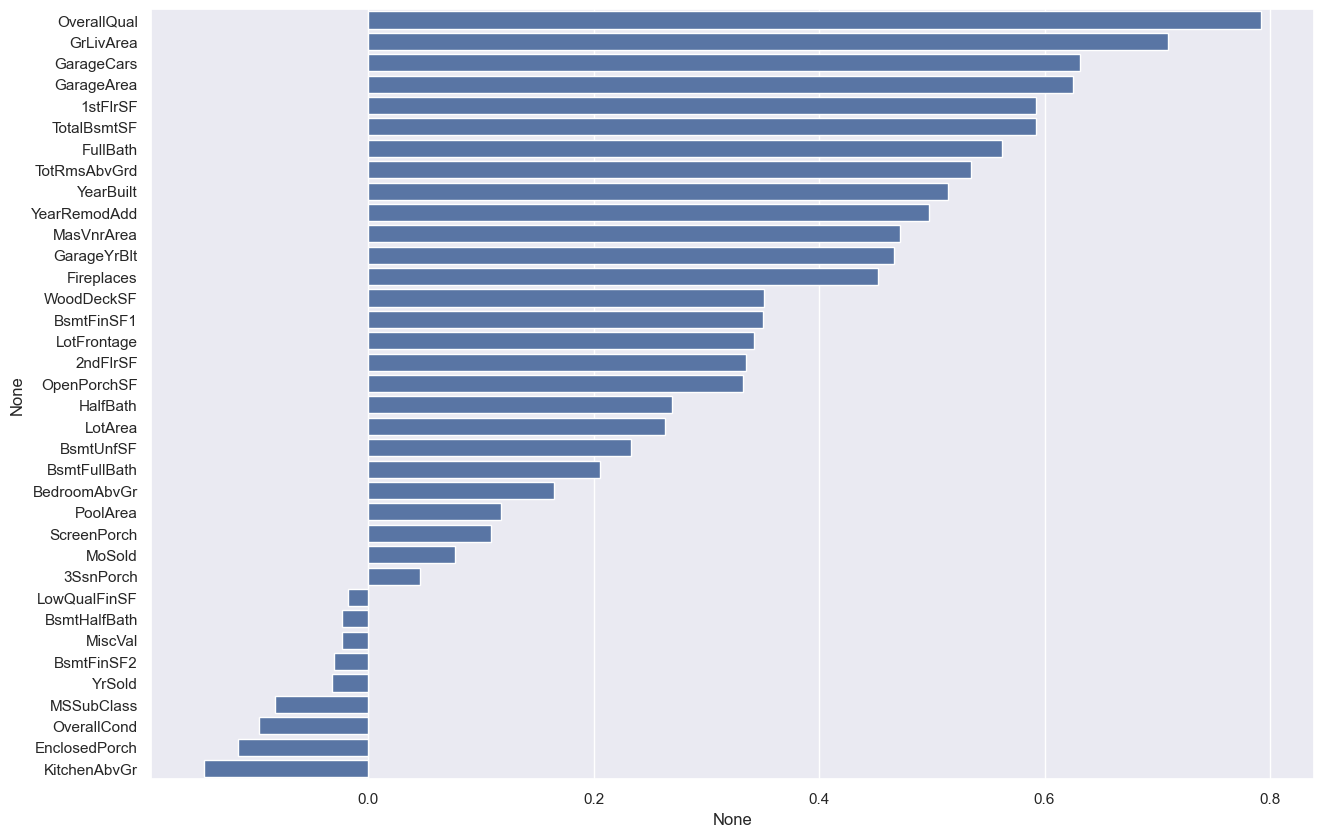

In [15]:
# выбираем только численые данные
numeric_data = X_train.select_dtypes([np.number])
# выбираем среднее значение
numeric_data_mean = numeric_data.mean()
# выбираем фичи с числами
numeric_features = numeric_data.columns

# заполним среднеим значением все NaN
X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

# считаем корреляцию
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

In [16]:
plt.show()

**Вывод:** датасет выглядит нормально, те признаки (OveralQ, GrLivArea, GargeCars, GarageArea), которые должны быть наиболее скоррелированными с ценой таковыми и оказались

## 3. Выбираем модель с регулязацией

In [19]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 32085.7681
Train RMSE = 35631.3131


Train оказался меньше Test, какие тому причины?
- Возможно выброс попал в train set, но не попал в test set
- Возможно помогла "регулязация"
- Кусок распределения полностью попал в test
- Плохой кусок распределения попал в train

## 3. Кросс-валидируемся

In [22]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n", ["%.4f" % x for x in cv_scores])
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
 ['-38825.3172', '-45278.9230', '-31405.3380', '-33890.1048', '-73848.3061', '-24142.7915', '-45523.7066', '-52861.2908', '-26094.3376', '-29693.5005']
Mean CV MSE = 40156.3616


Вывод: видимо выбросы всё-таки есть (см. 73к ошибка и 24к ошибка)

## 4. Определяем baseline

выберем константу, являющаяся медианной ценой участка за бейзлайн

In [25]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape), squared=False))
print("Train RMSE with best constant = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape), squared=False))

Test RMSE with best constant = 76636.5188
Train RMSE with best constant = 80588.6191


**Вывод:** ну средний результат лучше на 40к. неплохо!

## 6. Интерпретируем модель. Замеряем веса 

Попытаемся определить какие признаки модель выделила как самые важные

In [28]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

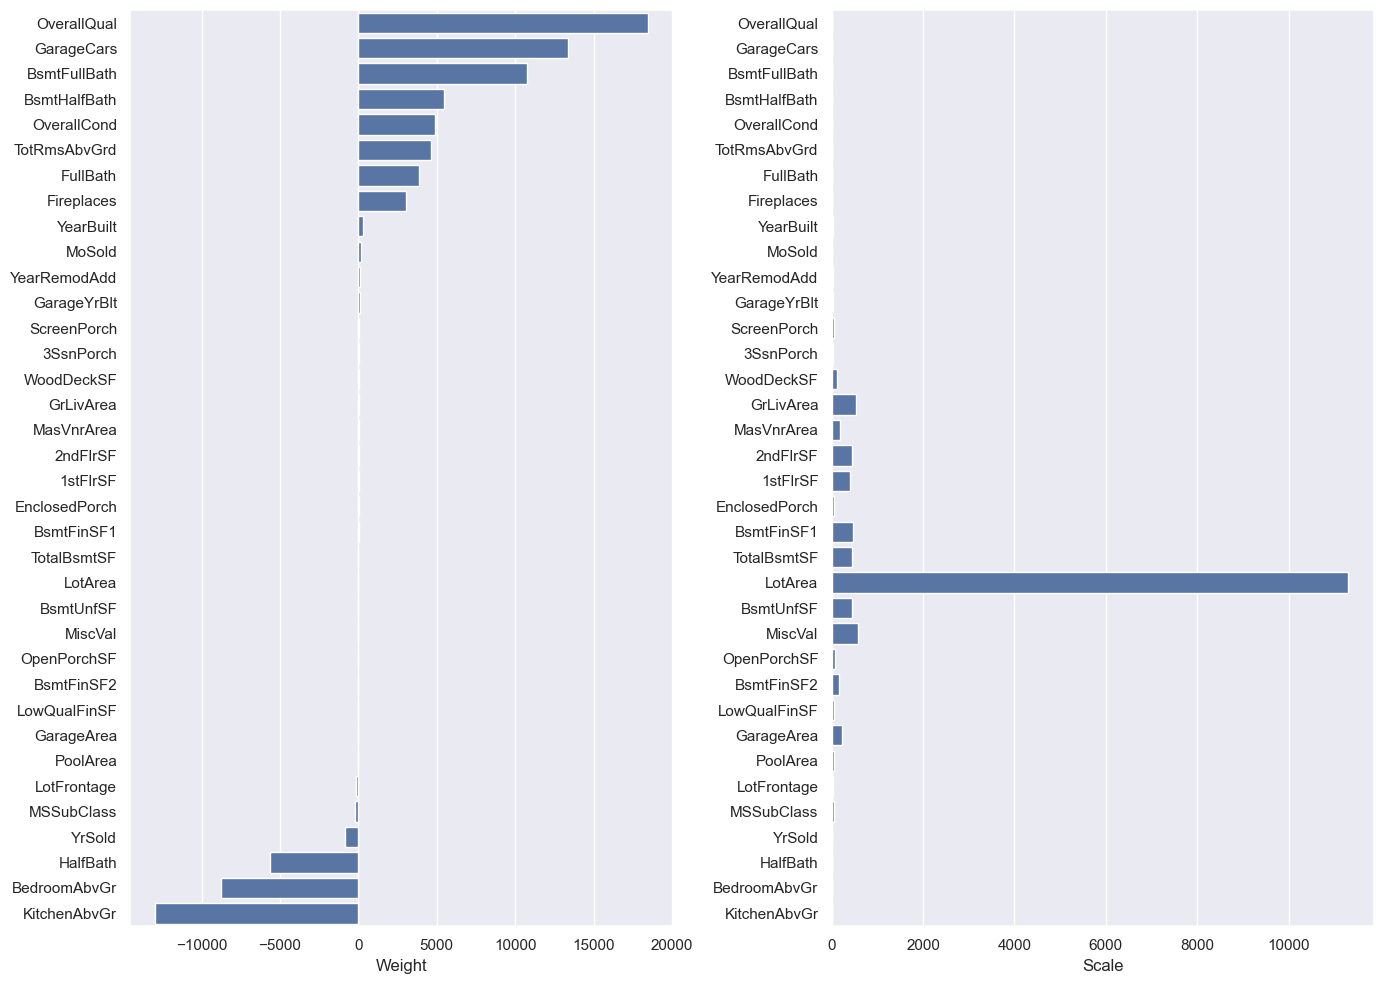

In [29]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())
plt.show()

Однако величина весов непоказательна в силу различных распределений (scale) изначальных величин признаков. Поэтому определить какой показатель важно учитывать для модели - неясно.

## 7. Нормализуем наши признаки

In [32]:
from sklearn.preprocessing import StandardScaler

# стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# применение модели
model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 32085.3150
Train RMSE = 35631.2160


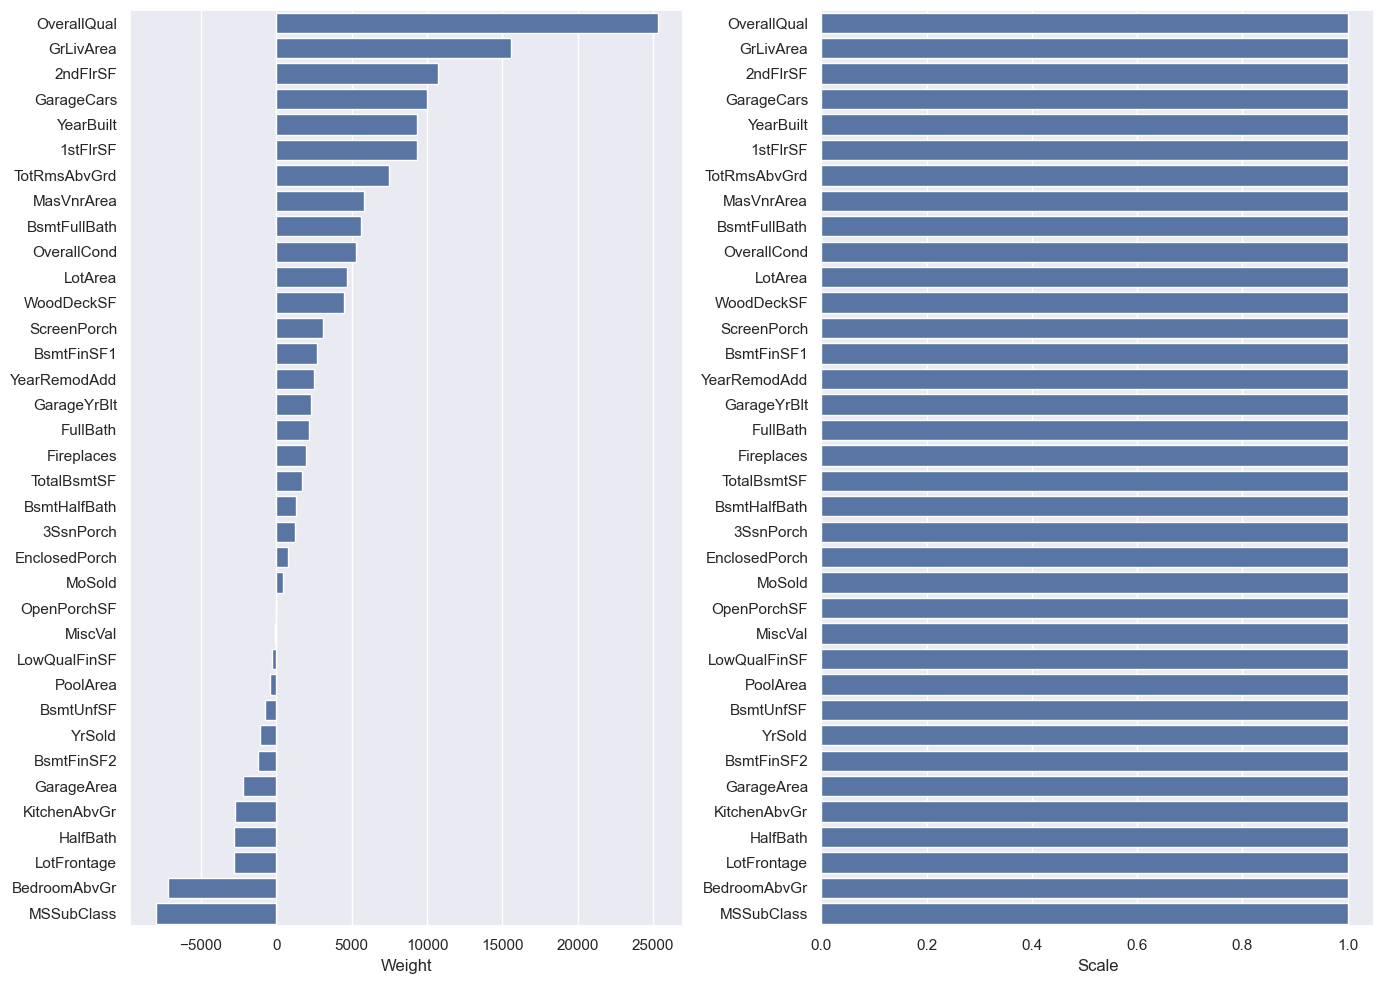

In [33]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)
plt.show()

**Вывод**: теперь мы можем понять какие признаки вносят существенный вклад в оценку цены дома (и действительно, смотря на корреляции первые три признака совпадают)

## 8. Подбор гиперпараметров модели


Подберем коэффицент регуляризации

Best alpha = 297.6351


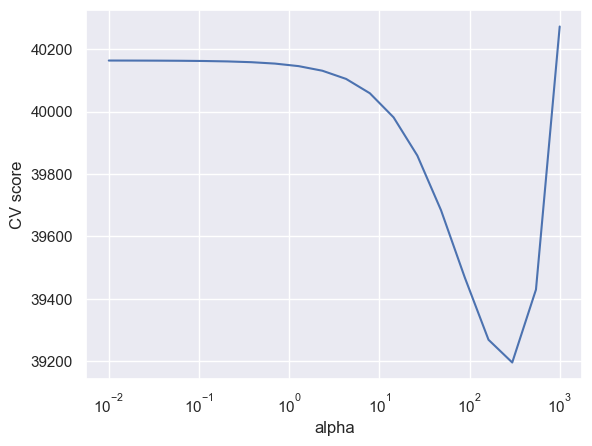

In [37]:
alphas = np.logspace(-2, 3, 20)
# метод перебора гиперпараметра
# первый аргумент - функция
# второй аргумент - перебираемые значения параметра
# третий аргумент - функция потерь
# четвертый аргумент - кросс-валидация по n блоков
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

Альфа дала +1к к точности!

## 9. Пайплайн

Воспользуемся классом Pipeline для обучения модели

In [40]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 31703.3590


# Преобразование категориальных признаков

## 10. One hot encoder 

Создадим список всех категориальных признаков и заполним NaNы для них

In [44]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Через пайплайн обучим модель с учетом категориальных признаков и ohe

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 26072.2754


In [47]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 293)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось. Обучим линейную регрессию с l1-регуляризатором - она зануляет часть весов, что уменьшает вероятность переобучения модели

In [49]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE = 26446.6016


In [50]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 31


Best alpha = 263.6651


Text(0, 0.5, 'CV score')

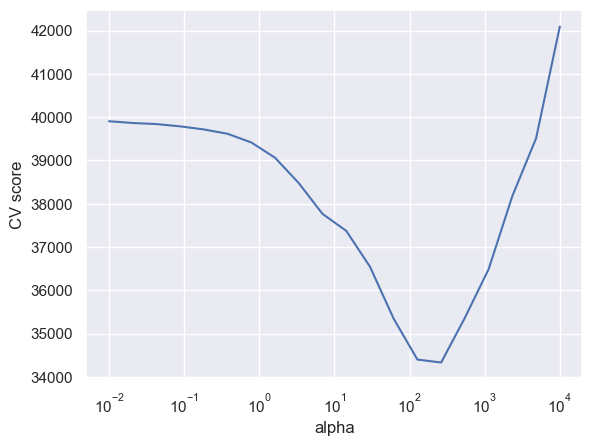

In [51]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [52]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 25645.3918


## 11. Убираем выбросы

Для начала взглянем на распределение остатков

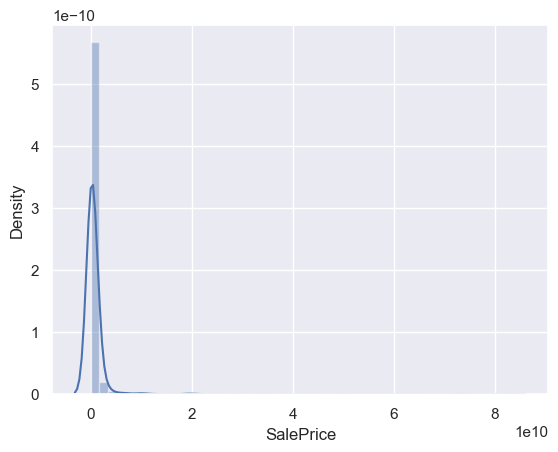

In [55]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)
plt.show()

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Для этого ограничимся 95 квантилем

In [57]:
mask = (error < np.quantile(error, 0.95))

In [58]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 24963.5948


## 12. Спрямление

Нарисуем график распредления Y от OverallQual, который даёт наибольшую корелляцию

Text(0, 0.5, 'SalePrice')

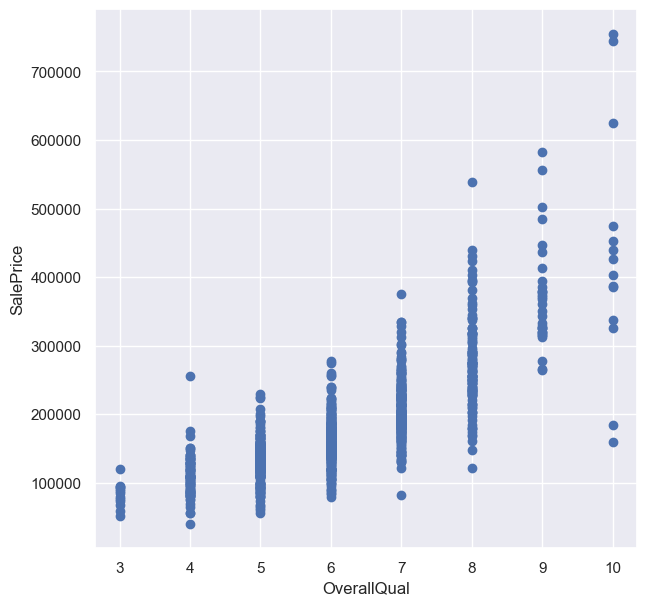

In [61]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train.OverallQual, y_train)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

Видим четкое распредление на кластеры по этому признаку. Тогда обучим модель под дешевые дома и под дорогие

Распределяем данные

In [64]:
threshold = 5
mask = (X_train.OverallQual <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

Обучаем модель

In [66]:
column_transformer1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer1),
    ('regression', Ridge())
])

column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', Ridge())
])

model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
mask_test = (X_test.OverallQual <= threshold)
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 27150.0115


Получили ошибку, которая в 4 раза меньше бэйзлайна